# Used Car Prices CarGurus
## Regression: XGBoost GPU
### Hyperopt Hyperparameter Optimization

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install xgboost==1.5.2
!pip install eli5
!pip install shap
import os
import random
import numpy as np
import warnings
import sys
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import joblib
from xgboost import XGBRegressor, plot_importance
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import csv
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import ast
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import eli5 
from eli5.sklearn import PermutationImportance 
import webbrowser
from eli5.formatters import format_as_dataframe
import shap
warnings.filterwarnings('ignore')
my_dpi = 96
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 173.6 MB 9.6 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 32.2 MB/s 
     |████████████████████████████████| 133 kB 74.8 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=e0052c2555531faa8dbdfd63bd3c7755a1fa9dbb1cb15bf2a82aac6086c12561
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver doe

In [ ]:
# Set seed 
seed_value = 42
os.environ['usedCars_xgbGPU'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/Data/

/content/drive/MyDrive/UsedCarsCarGurus/Data


In [ ]:
# Read data 
trainDF = pd.read_csv('usedCars_trainSet.csv', low_memory=False)
testDF = pd.read_csv('usedCars_testSet.csv', low_memory=False)

# Partition train/test sets
X_train = trainDF.drop(columns = ['price'])
y_train = trainDF[['price']]
X_test = testDF.drop(columns = ['price'])
y_test = testDF[['price']]

In [ ]:
# Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

## 100 Trials 10-Fold Cross Validation

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Define the number of trials
NUM_EVAL = 100

# Set same k-folds for reproducibility
kfolds = KFold(n_splits=10, shuffle=True, random_state=seed_value)

xgb_tune_kwargs= {
    'n_estimators': hp.choice('n_estimators', np.arange(100, 500, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'subsample': hp.uniform('subsample', 0.25, 0.75),
    'gamma': hp.uniform('gamma', 0, 9),
    'learning_rate': hp.uniform('learning_rate', 1e-4, 0.3),
    'reg_alpha': hp.choice('reg_alpha', np.arange(0, 30, dtype=int)),
    'reg_lambda': hp.uniform('reg_lambda', 0, 3),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.05, 0.5),  
    'min_child_weight': hp.choice('min_child_weight', np.arange(0, 10, 
                                                                dtype=int))
    }

In [ ]:
# Define a function for optimization of hyperparameters
def xgb_hpo(config):
    """XGBoost HPO"""
    
    joblib.dump(bayesOpt_trials, 'xgb_Hyperopt_100_GPU.pkl')

    # Keep track of evaluations
    global ITERATION
    
    ITERATION += 1  
    
    # Parameters that are integers to remain integers
    config['n_estimators'] = int(config['n_estimators'])   
    
    # Start hyperopt at 3 for max_depth   
    config['max_depth'] = int(config['max_depth']) + 3
    
    # Define model type
    xgb = XGBRegressor(
        objective='reg:squarederror',
        booster='gbtree', 
        tree_method='gpu_hist',    
        scale_pos_weight=1,
        use_label_encoder=False,
        early_stopping_rounds=10,
        random_state=seed_value,
        verbosity=0,
        **config)
    
    # Start timer for each trial
    start = timer()
    
    # Perform k_folds cross validation to find lower error
    scores = -cross_val_score(xgb, X_train, y_train,
                              scoring='neg_root_mean_squared_error',
                              cv=kfolds)
    run_time = timer() - start

    # Extract the best score
    rmse = np.mean(scores)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([rmse, config, ITERATION, run_time])
    
    return {'loss': rmse, 'params': config, 'iteration': ITERATION, 
            'train_time': run_time, 'status': STATUS_OK}    

In [ ]:
# Optimization algorithm
tpe_algorithm = tpe.suggest

# File to save first results
out_file = '/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/trialOptions/XGB_trials_100_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_trials = Trials()

In [ ]:
# Begin HPO trials 
# Start timer for experiment
search_time_start = time.time()
if os.path.isfile('xgb_Hyperopt_100_GPU.pkl'): 
  bayesOpt_trials = joblib.load('xgb_Hyperopt_100_GPU.pkl')
else: 
  best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                    max_evals=NUM_EVAL, trials=bayesOpt_trials,
                    rstate=np.random.RandomState(42))
# End timer for experiment
print('Time to run HPO:', time.time() - search_time_start)

100%|██████████| 100/100 [3:31:36<00:00, 126.96s/it, best loss: 2364.8525302641146]
Time to run HPO: 12696.534128189087


In [ ]:
# Sort the trials with lowest loss (lowest RMSE) first
bayesOpt_trials_results = sorted(bayesOpt_trials.results, 
                                 key=lambda x: x['loss'])
print('Top two trials with the lowest loss (lowest RMSE)')
print(bayesOpt_trials_results[:2])

Top two trials with the lowest loss (lowest RMSE)
[{'loss': 2364.8525302641146, 'params': {'colsample_bylevel': 0.40453201002017725, 'colsample_bytree': 0.6861694985717817, 'gamma': 2.8387316646013727, 'learning_rate': 0.07800387124280966, 'max_depth': 12, 'min_child_weight': 2, 'n_estimators': 444, 'reg_alpha': 13, 'reg_lambda': 0.24997194811603288, 'subsample': 0.6879820618941104}, 'iteration': 97, 'train_time': 410.1135096270009, 'status': 'ok'}, {'loss': 2374.5711576887543, 'params': {'colsample_bylevel': 0.3785372983295038, 'colsample_bytree': 0.5829140396364186, 'gamma': 0.3686342226972439, 'learning_rate': 0.06908144715132526, 'max_depth': 12, 'min_child_weight': 3, 'n_estimators': 315, 'reg_alpha': 18, 'reg_lambda': 0.23760705388349476, 'subsample': 0.6792343786730903}, 'iteration': 67, 'train_time': 243.83826919999956, 'status': 'ok'}]


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/trialOptions/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/trialOptions


In [ ]:
# Access results
results = pd.read_csv('XGB_trials_100_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_model = XGBRegressor(objective='reg:squarederror', 
                                booster='gbtree',
                                tree_method='gpu_hist', 
                                scale_pos_weight=1,
                                use_label_encoder=False,                           
                                random_state=seed_value, 
                                verbosity=0, 
                                **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGB_HPO_trials100_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGB_HPO_trials100_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for XGBoost HPO 100 GPU trials')
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))


Model Metrics for XGBoost HPO 100 GPU trials
MAE train: 971.178, test: 1687.549
MSE train: 1800160.672, test: 5414822.708
RMSE train: 1341.701, test: 2326.977
R^2 train: 0.980, test: 0.941


In [ ]:
# Evaluate on the testing data 
print('The best model from Bayes optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test, 
                                                                                                            y_test_pred)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 5414822.70802 MSE on the test set.
This was achieved after 97 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/bayesParams/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_XGB_HPO_100_GPU.csv', index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

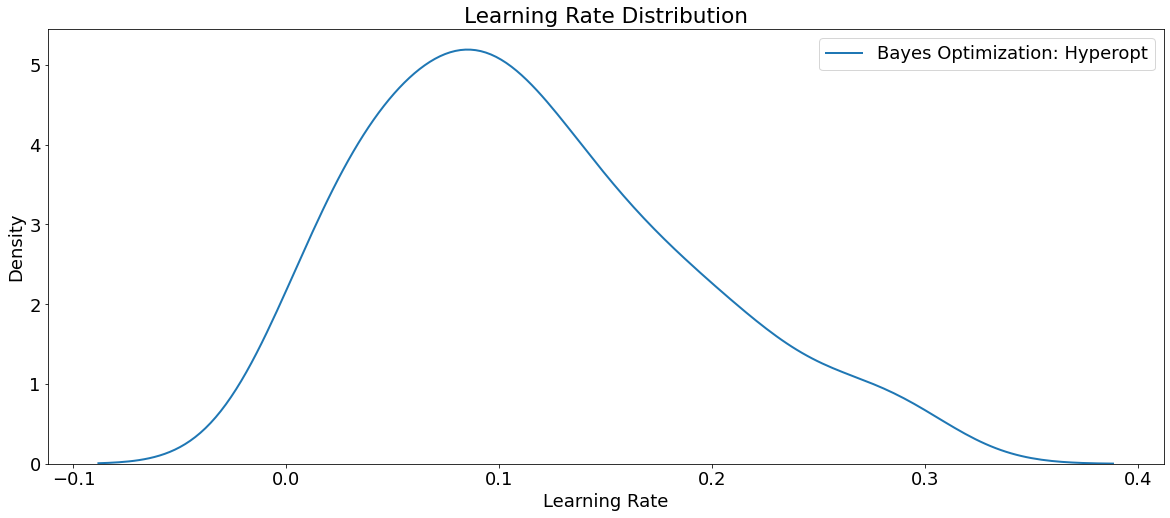

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization: Hyperopt', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

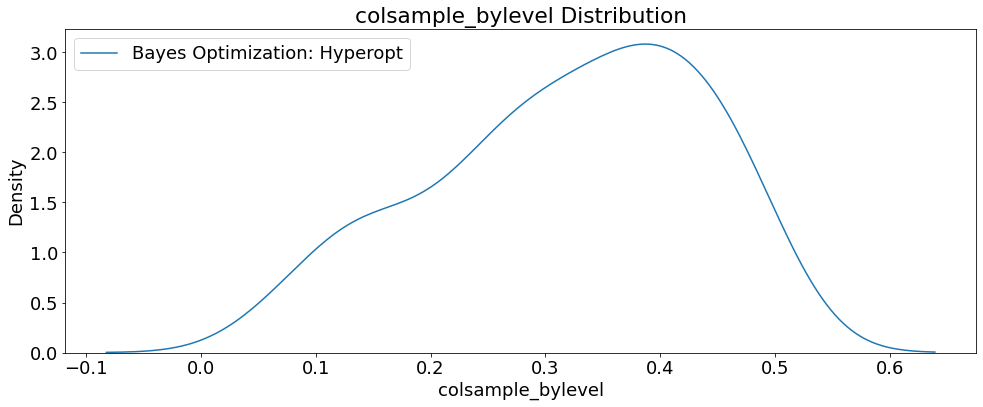

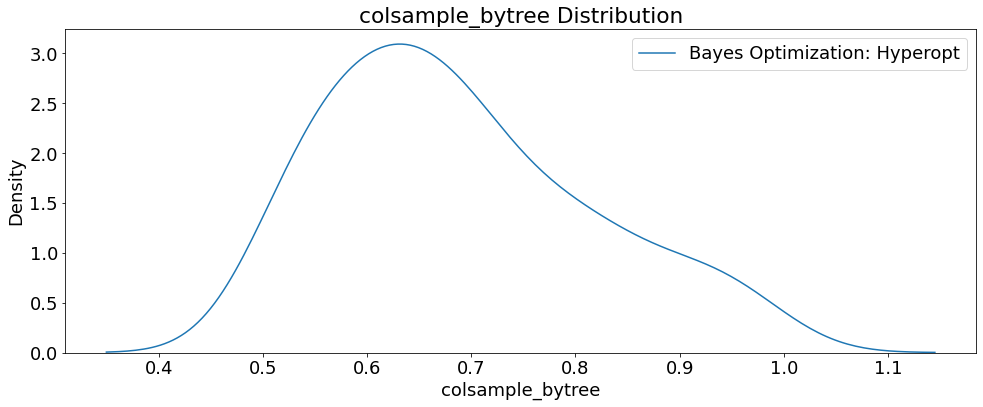

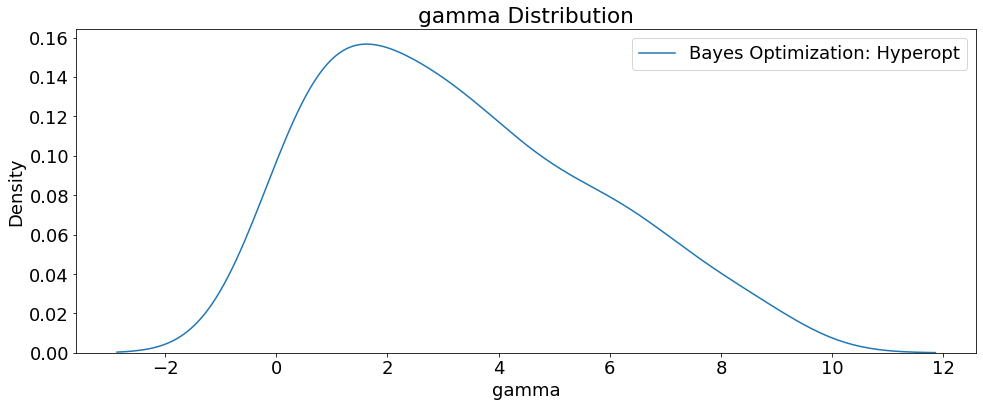

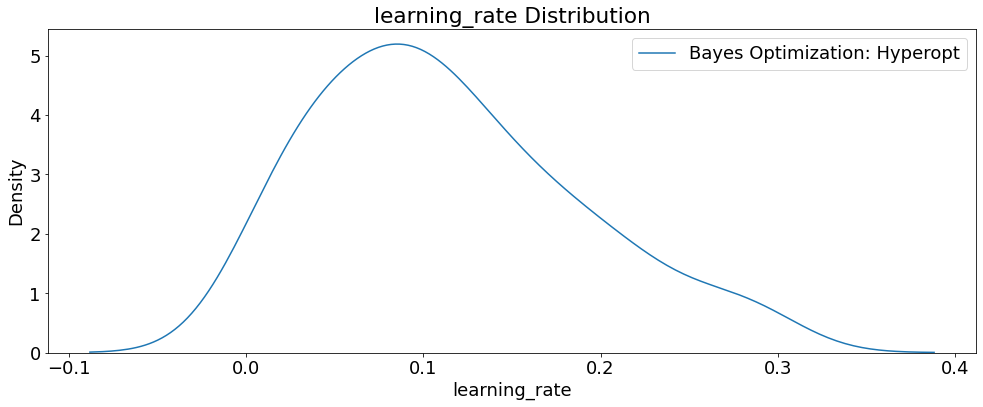

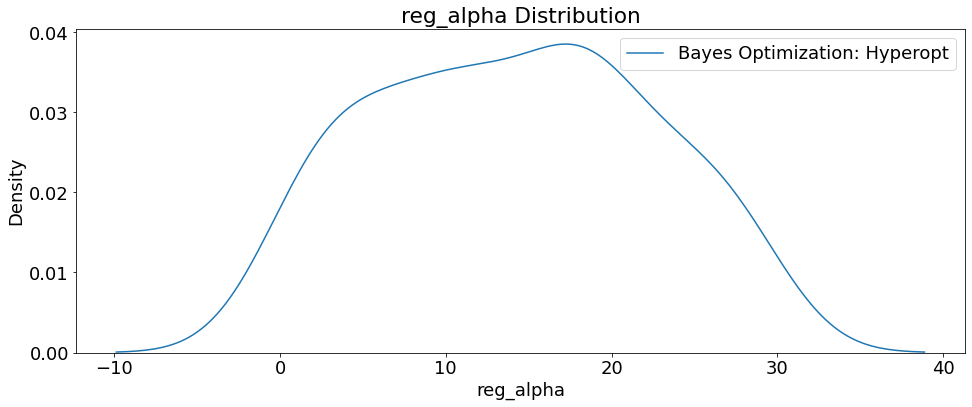

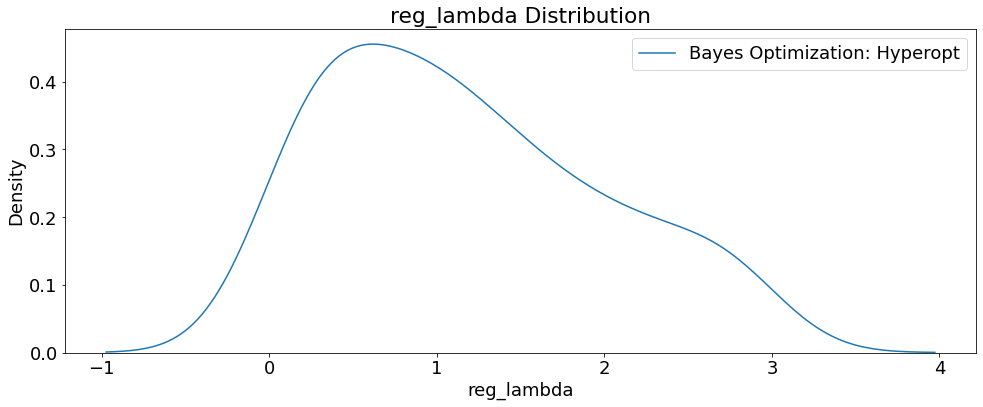

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization: Hyperopt')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

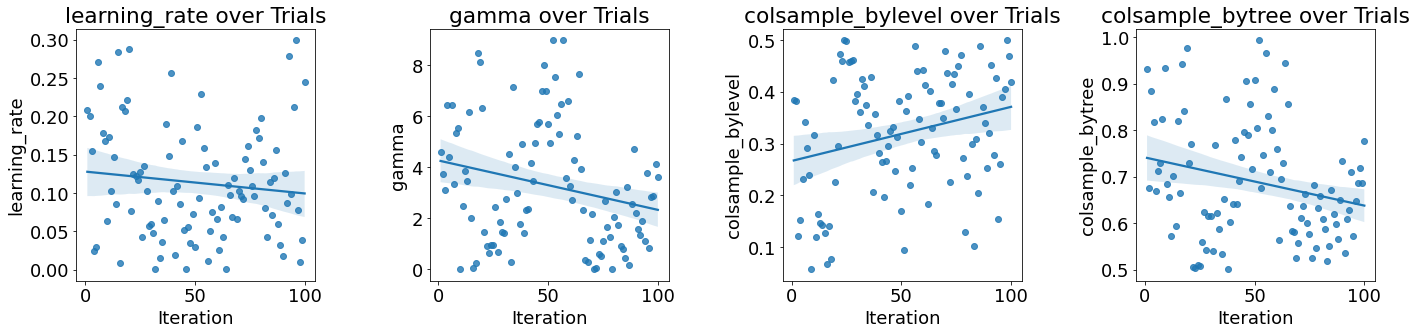

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

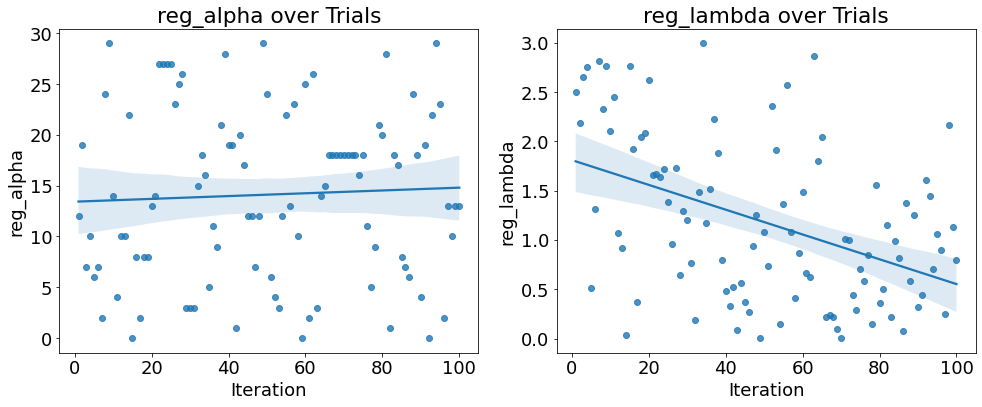

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']): 
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_Explanations


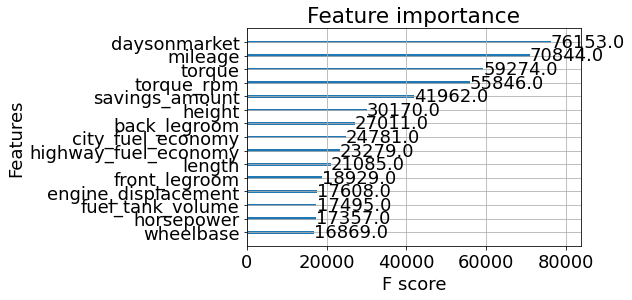

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGB_HPO_100_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Training Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_train)

<Figure size 432x288 with 0 Axes>

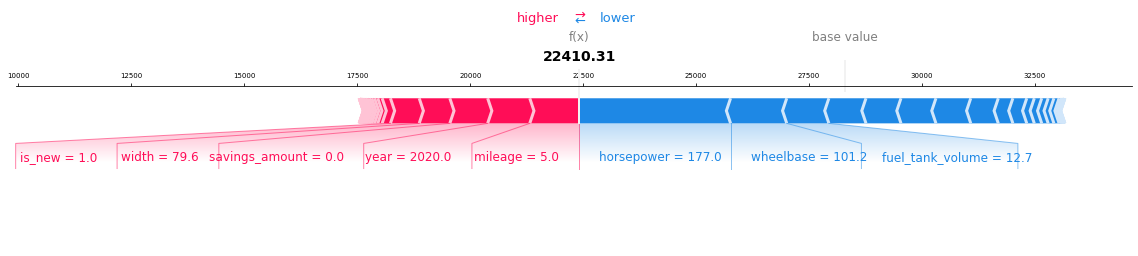

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], 
                show=False, matplotlib=True).savefig('XGB_HPO_100_GPU_ShapForcePlot_TrainSet.png', 
                                                     dpi=my_dpi*10, 
                                                     bbox_inches='tight');

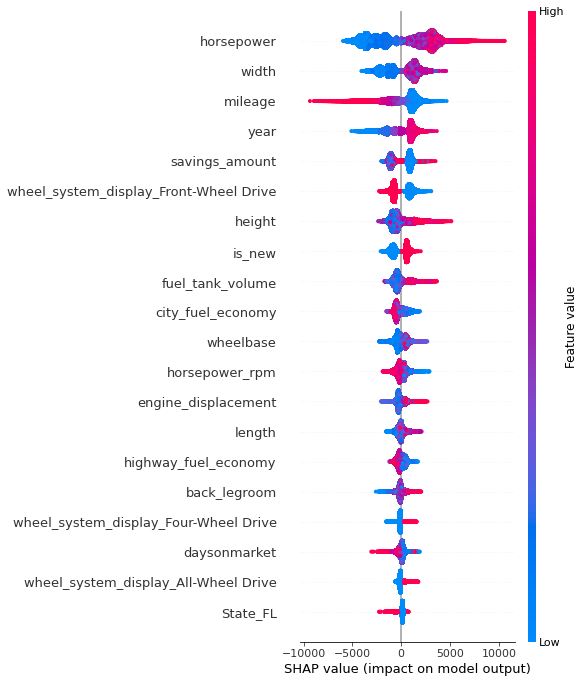

In [ ]:
# Training Set: Summarize the effects of all the features
shap.summary_plot(shap_values, X_train, show=False)
fig.savefig('XGB_HPO_100_GPU_ShapSummary_TrainSet.png', dpi=my_dpi*10, 
            bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
shap_values = explainer.shap_values(X_test)

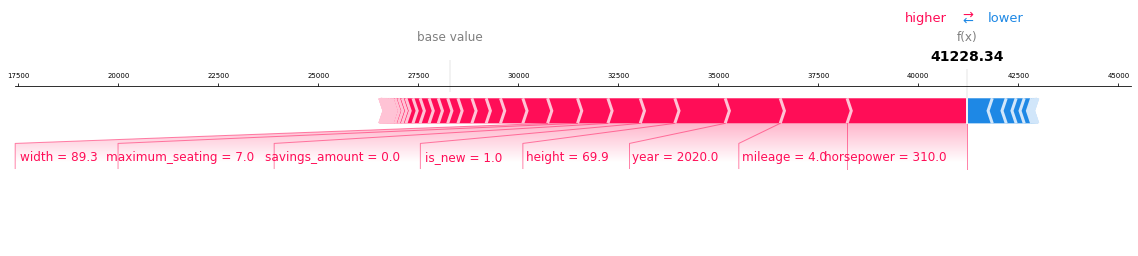

In [ ]:
# Visualize the first prediction's explanation
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], 
                show=False, matplotlib=True).savefig('XGB_HPO_100_GPU_ShapForcePlot_TestSet.png', 
                                                     dpi=my_dpi*10, 
                                                     bbox_inches='tight');

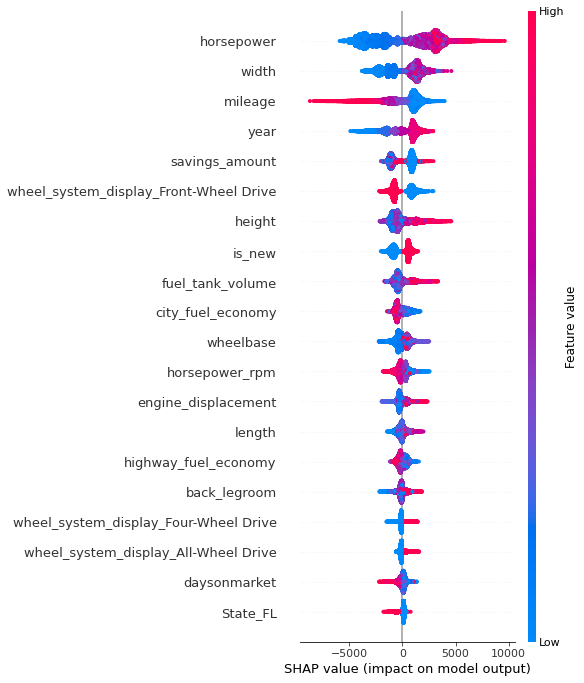

In [ ]:
# Test Set: Summarize the effects of all the features
shap.summary_plot(shap_values, X_test, show=False)
fig.savefig('XGB_HPO_100_GPU_ShapSummary_TestSet.png', dpi=my_dpi*10, 
            bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

In [ ]:
# Get the weights
X_test1 = pd.DataFrame(X_test, columns=X_test.columns)                                                                    

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test1.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes100_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes100_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj 

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_100_GPU_WeightsExplain.csv', index=False)

## 300 Trials 10-Fold Cross Validation

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Define the number of trials
NUM_EVAL = 300

In [ ]:
# Define a function for optimization of hyperparameters
def xgb_hpo(config):
    """XGBoost HPO"""
    
    joblib.dump(bayesOpt_trials, 'xgb_Hyperopt_300_GPU.pkl')
    
    # Keep track of evaluations
    global ITERATION
    
    ITERATION += 1  
    
    # Parameters that are integers to remain integers
    config['n_estimators'] = int(config['n_estimators'])   
    
    # Start hyperopt at 3 for max_depth   
    config['max_depth'] = int(config['max_depth']) + 3
    
    # Define model type
    xgb = XGBRegressor(
        objective='reg:squarederror',
        booster='gbtree', 
        tree_method='gpu_hist',    
        scale_pos_weight=1,
        use_label_encoder=False,
        early_stopping_rounds=10,
        random_state=seed_value,
        verbosity=0,
        **config)
    
    # Start timer for each trial
    start = timer()
    
    # Perform k_folds cross validation to find lower error
    scores = -cross_val_score(xgb, X_train, y_train,
                              scoring='neg_root_mean_squared_error',
                              cv=kfolds)
    run_time = timer() - start

    # Extract the best score
    rmse = np.mean(scores)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([rmse, config, ITERATION, run_time])
    
    return {'loss': rmse, 'params': config, 'iteration': ITERATION, 
            'train_time': run_time, 'status': STATUS_OK}    

In [ ]:
# Optimization algorithm
tpe_algorithm = tpe.suggest

# File to save first results
out_file = '/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/trialOptions/XGB_trials_300_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_trials = Trials()

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
if os.path.isfile('xgb_Hyperopt_300_GPU.pkl'): 
    bayesOpt_trials = joblib.load('xgb_Hyperopt_300_GPU.pkl')
    best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest, 
                      max_evals=NUM_EVAL, trials=bayesOpt_trials,
                      rstate=np.random.RandomState(42))
else: 
    best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest, 
                      max_evals=NUM_EVAL, trials=bayesOpt_trials,
                      rstate=np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Start Time           2022-02-13 01:26:44.089604
100%|██████████| 300/300 [13:50:32<00:00, 166.11s/it, best loss: 2360.9404778388325]
Start Time           2022-02-13 01:26:44.089604
End Time             2022-02-13 15:17:16.532228
13:50:32


In [ ]:
# Sort the trials with lowest loss (lowest RMSE) first
bayesOpt_trials_results = sorted(bayesOpt_trials.results, 
                                 key=lambda x: x['loss'])
print('Top two trials with the lowest loss (lowest RMSE)')
print(bayesOpt_trials_results[:2])

Top two trials with the lowest loss (lowest RMSE)
[{'loss': 2360.9404778388325, 'params': {'colsample_bylevel': 0.46810548016285225, 'colsample_bytree': 0.5308143433747501, 'gamma': 1.6729089829733979, 'learning_rate': 0.08523827415243382, 'max_depth': 12, 'min_child_weight': 0, 'n_estimators': 443, 'reg_alpha': 18, 'reg_lambda': 2.530445524613025, 'subsample': 0.7315224452498899}, 'iteration': 263, 'train_time': 427.44341490900115, 'status': 'ok'}, {'loss': 2361.7093181948267, 'params': {'colsample_bylevel': 0.49442563554429647, 'colsample_bytree': 0.5222615437047392, 'gamma': 1.5084072489168792, 'learning_rate': 0.06475205416794028, 'max_depth': 12, 'min_child_weight': 0, 'n_estimators': 414, 'reg_alpha': 18, 'reg_lambda': 2.2944311863133606, 'subsample': 0.7053963773567413}, 'iteration': 261, 'train_time': 383.9923600809998, 'status': 'ok'}]


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/trialOptions/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/trialOptions


In [ ]:
# Access results
results = pd.read_csv('XGB_300_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_PKL/

In [ ]:
# Re-create the best model and train on the training data
best_bayes_model = XGBRegressor(objective='reg:squarederror', 
                                booster='gbtree',
                                tree_method='gpu_hist', 
                                scale_pos_weight=1,
                                use_label_encoder=False,                           
                                random_state=seed_value,
                                verbosity=0, 
                                **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGB_HPO_trials300_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGB_HPO_trials300_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for XGBoost HPO 300 GPU trials')
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))


Model Metrics for XGBoost HPO 300 GPU trials
MAE train: 1055.897, test: 1698.187
MSE train: 2156346.027, test: 5453324.338
RMSE train: 1468.450, test: 2335.235
R^2 train: 0.976, test: 0.940


In [ ]:
# Evaluate on the testing data 
print('The best model from Bayes optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test, 
                                                                                                            y_test_pred)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 5453324.33829 MSE on the test set.
This was achieved after 263 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/bayesParams/

In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_XGB_HPO_300_GPU.csv', index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

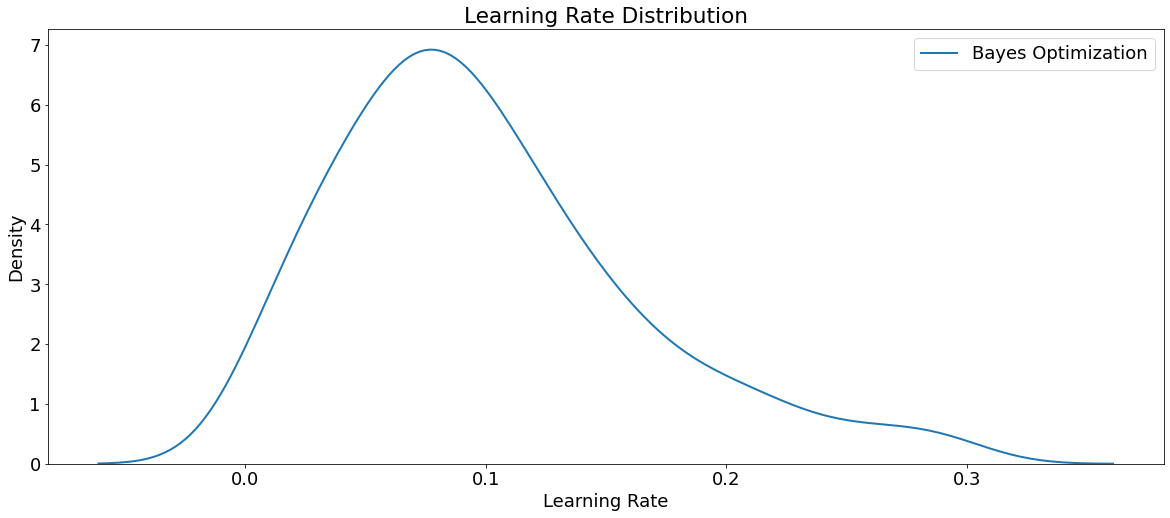

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

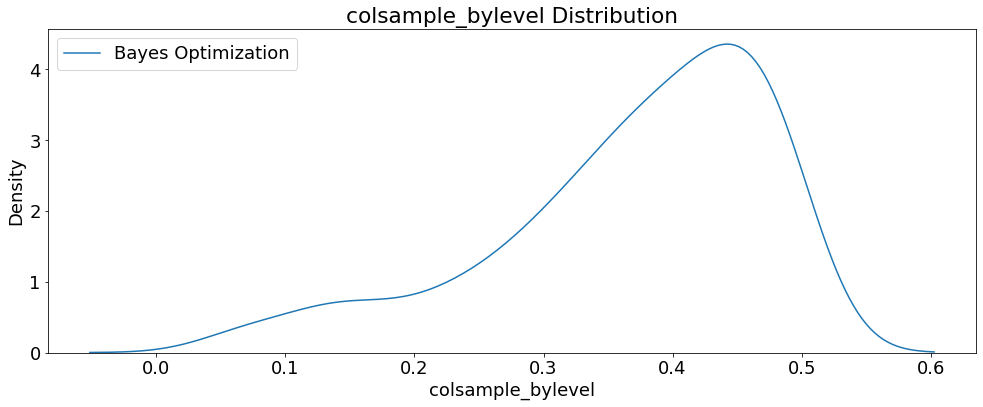

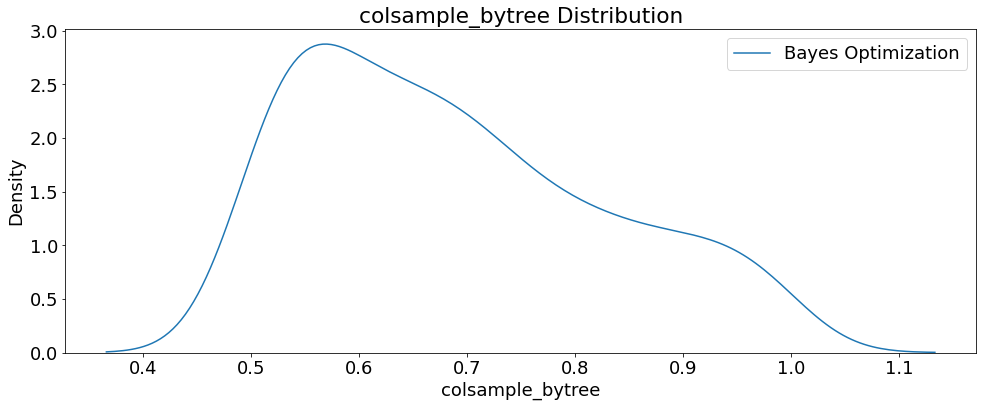

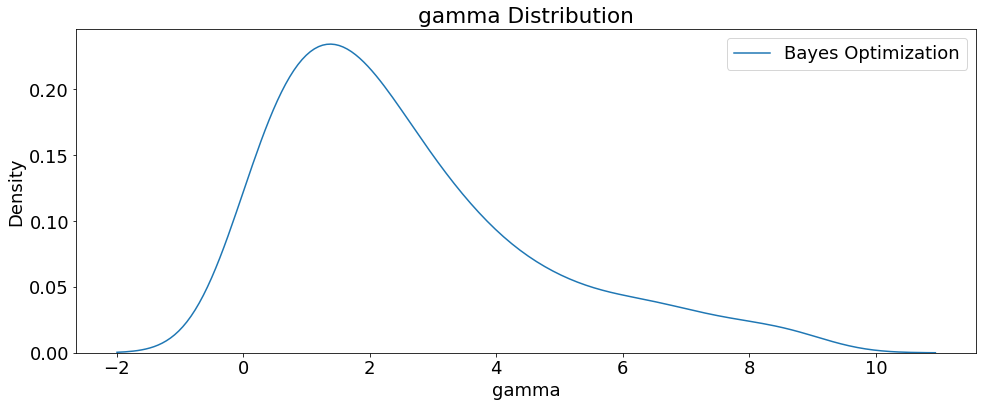

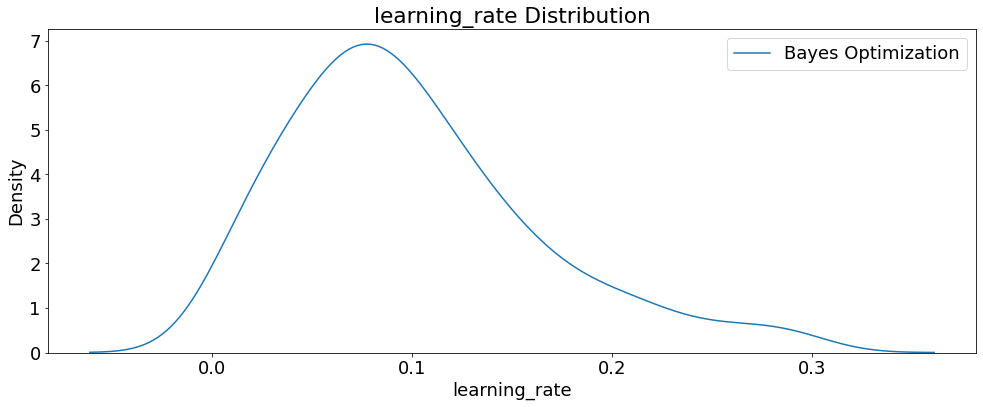

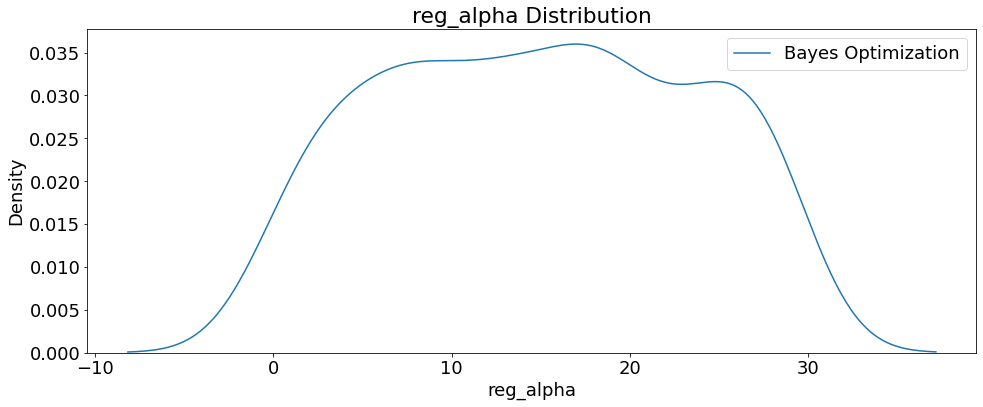

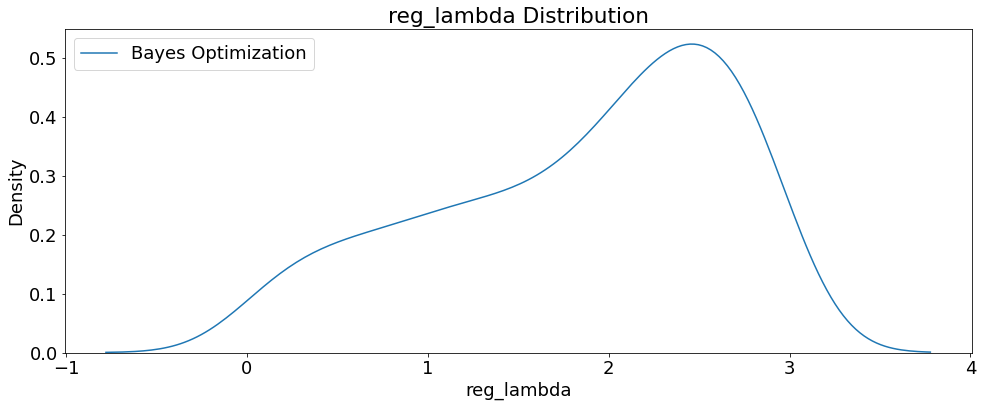

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

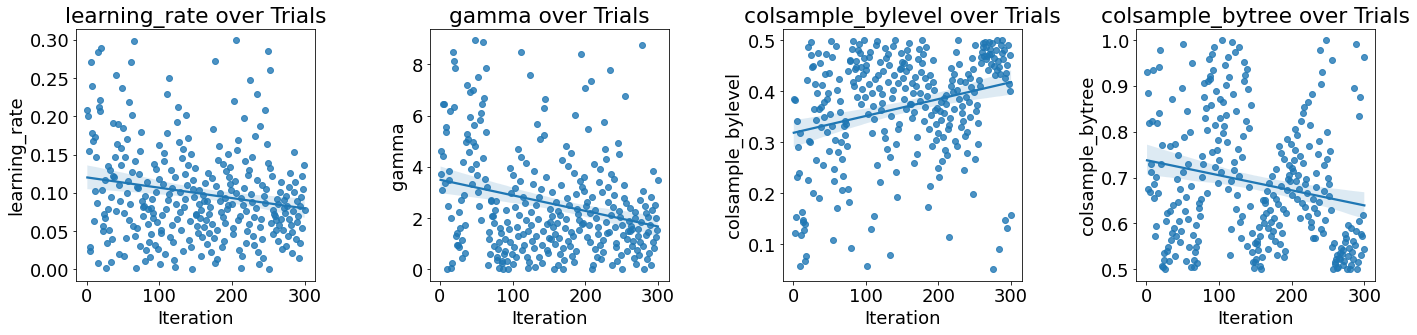

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

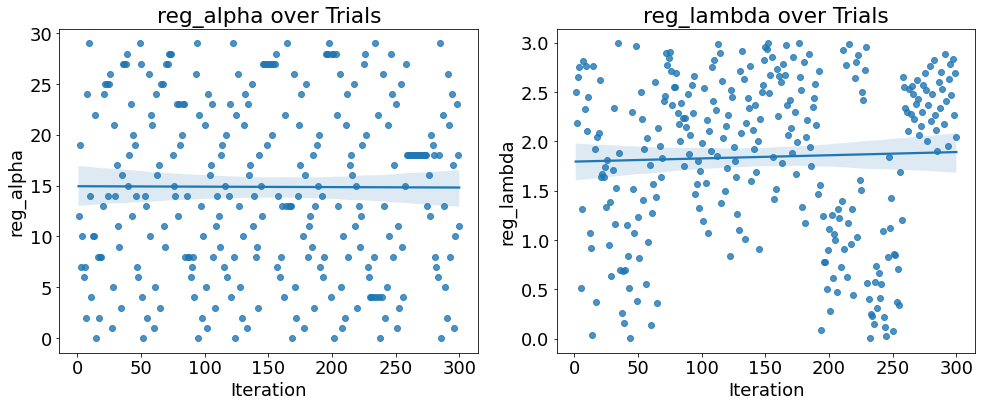

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']): 
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_Explanations/

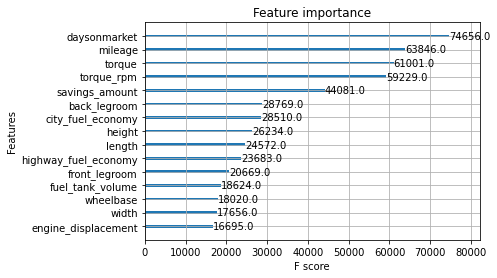

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGB_HPO_300_GPU_FeatureImportance.png', dpi=my_dpi*10,
            bbox_inches='tight')

In [ ]:
# Training Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


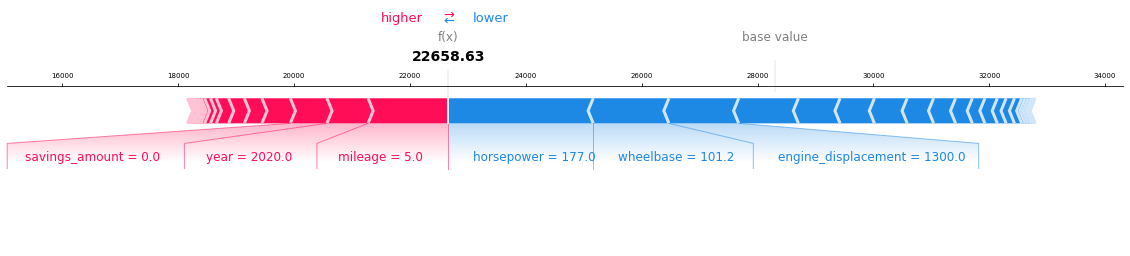

In [ ]:
# Visualize the first prediction's explanation
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], 
                show=False, matplotlib=True).savefig('XGB_HPO_300_GPU_ShapForcePlot_TrainSet.png', 
                                                     dpi=my_dpi*10, bbox_inches='tight');

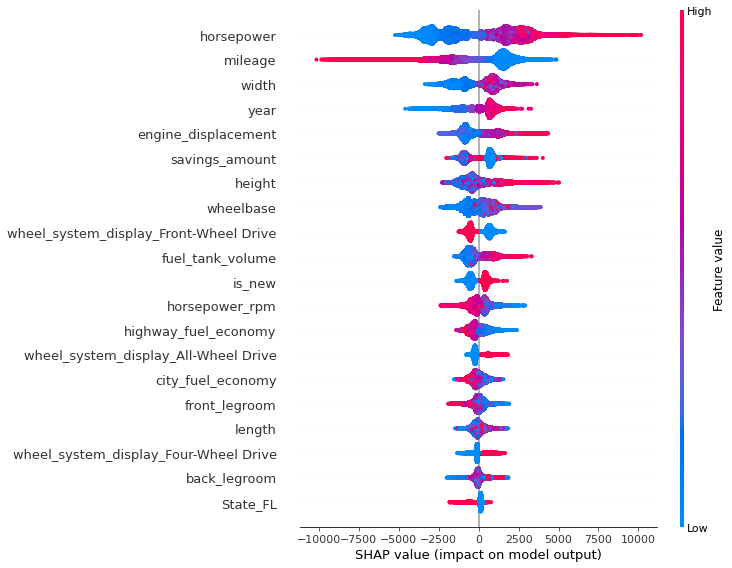

In [ ]:
# Training Set: Summarize the effects of all the features
shap.summary_plot(shap_values, X_train, show=False)
fig.savefig('XGB_HPO_300_GPU_ShapSummary_TrainSet.png', dpi=my_dpi*10, 
            bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

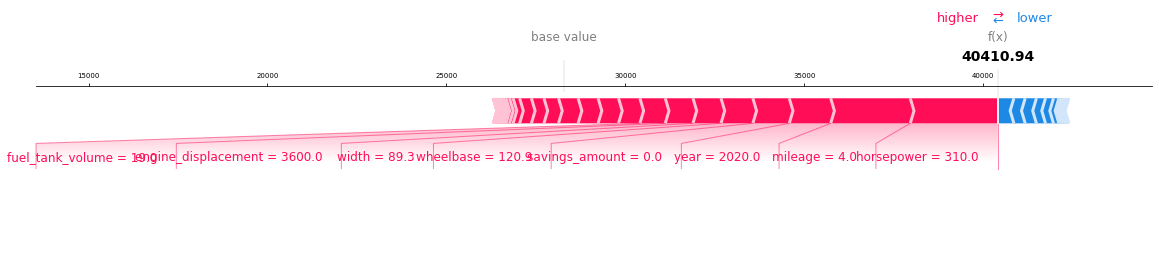

In [ ]:
# Visualize the first prediction's explanation
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], 
                show=False, matplotlib=True).savefig('XGB_HPO_300_GPU_ShapForcePlot_TestSet.png', 
                                                     dpi=my_dpi*10, 
                                                     bbox_inches='tight');

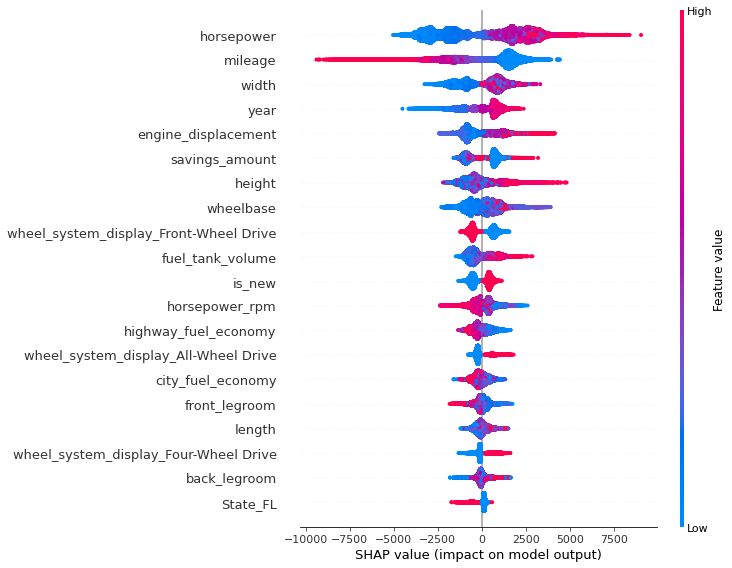

In [ ]:
# Test Set: Summarize the effects of all the features
shap.summary_plot(shap_values, X_test, show=False)
fig.savefig('XGB_HPO_300_GPU_ShapSummary_TestSet.png', dpi=my_dpi*10, 
            bbox_inches='tight')

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

In [ ]:
# Get the weights
X_test1 = pd.DataFrame(X_test, columns=X_test.columns)                                                                    

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test1.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_300_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_300_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj 

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_300_GPU_WeightsExplain.csv', index=False)

## Time Categories - 100 Trials 10-Fold Cross Validation 

In [ ]:
# Read data
df = pd.read_csv('usedCars_final.csv', low_memory=False)
df = df.drop_duplicates()
df['year'] = df['year'].astype(str)

# Prepare for partitioning data
X = df.drop(['price'], axis=1)
y = df['price']

In [ ]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=X.listed_date_yearMonth,
                                                    random_state=seed_value)

In [ ]:
# Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/trialOptions/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/trialOptions


In [ ]:
# Define the number of trials
NUM_EVAL = 100

In [ ]:
# Define a function for optimization of hyperparameters
def xgb_hpo(config):
    """XGBoost HPO"""

    joblib.dump(bayesOpt_trials, 'xgb_Hyperopt_100_GPU_TimeCategories.pkl')

    # Keep track of evaluations
    global ITERATION
    
    ITERATION += 1  
    
    # Parameters that are integers to remain integers
    config['n_estimators'] = int(config['n_estimators'])   
    
    # Start hyperopt at 3 for max_depth   
    config['max_depth'] = int(config['max_depth']) + 3
    
    # Define model type
    xgb = XGBRegressor(
        objective='reg:squarederror',
        booster='gbtree', 
        tree_method='gpu_hist',    
        scale_pos_weight=1,
        use_label_encoder=False,
        early_stopping_rounds=10,
        random_state=seed_value,
        verbosity=0,
        **config)
    
    # Start timer for each trial
    start = timer()
    
    # Perform k_folds cross validation to find lower error
    scores = -cross_val_score(xgb, X_train, y_train,
                              scoring='neg_root_mean_squared_error',
                              cv=kfolds)
    run_time = timer() - start

    # Extract the best score
    rmse = np.mean(scores)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([rmse, config, ITERATION, run_time])
    
    return {'loss': rmse, 'params': config, 'iteration': ITERATION, 
            'train_time': run_time, 'status': STATUS_OK}    

In [ ]:
# File to save first results
out_file = '/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/trialOptions/XGB_100_GPU_TimeCategories.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_trials = Trials()

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
if os.path.isfile('xgb_Hyperopt_100_GPU_TimeCategories.pkl'): 
    bayesOpt_trials = joblib.load('xgb_Hyperopt_100_GPU_TimeCategories.pkl')
    best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest, 
                      max_evals=NUM_EVAL, trials=bayesOpt_trials,
                      rstate=np.random.RandomState(42))
else: 
    best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest, 
                      max_evals=NUM_EVAL, trials=bayesOpt_trials,
                      rstate=np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Start Time           2022-02-21 22:12:23.484961
100%|██████████| 100/100 [4:08:50<00:00, 149.30s/it, best loss: 2372.0802466068767]
Start Time           2022-02-21 22:12:23.484961
End Time             2022-02-22 02:21:13.947534
4:08:50


In [ ]:
# Sort the trials with lowest loss (lowest RMSE) first
bayesOpt_trials_results = sorted(bayesOpt_trials.results, 
                                 key=lambda x: x['loss'])
print('Top two trials with the lowest loss (lowest RMSE)')
print(bayesOpt_trials_results[:2])

Top two trials with the lowest loss (lowest RMSE)
[{'loss': 2372.0802466068767, 'params': {'colsample_bylevel': 0.40453201002017725, 'colsample_bytree': 0.6861694985717817, 'gamma': 2.8387316646013727, 'learning_rate': 0.07800387124280966, 'max_depth': 12, 'min_child_weight': 2, 'n_estimators': 444, 'reg_alpha': 13, 'reg_lambda': 0.24997194811603288, 'subsample': 0.6879820618941104}, 'iteration': 97, 'train_time': 447.49601699699997, 'status': 'ok'}, {'loss': 2374.471272557447, 'params': {'colsample_bylevel': 0.3785372983295038, 'colsample_bytree': 0.5829140396364186, 'gamma': 0.3686342226972439, 'learning_rate': 0.06908144715132526, 'max_depth': 12, 'min_child_weight': 3, 'n_estimators': 315, 'reg_alpha': 18, 'reg_lambda': 0.23760705388349476, 'subsample': 0.6792343786730903}, 'iteration': 67, 'train_time': 278.37577700699876, 'status': 'ok'}]


In [ ]:
# Access results
results = pd.read_csv('XGB_trials_100_GPU_TimeCategories.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_PKL/

In [ ]:
# Re-create the best model and train on the training data
best_bayes_model = XGBRegressor(objective='reg:squarederror', 
                                booster='gbtree',
                                tree_method='gpu_hist', 
                                scale_pos_weight=1,
                                use_label_encoder=False,                           
                                random_state=seed_value, 
                                verbosity=0, 
                                **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGB_HPO_trials100_GPU_TimeCategories.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGB_HPO_trials100_GPU_TimeCategories.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for XGBoost HPO 100 GPU trials')
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))


Model Metrics for XGBoost HPO 100 GPU trials Time Categories
MAE train: 967.198, test: 1691.640
MSE train: 1787925.641, test: 5445684.990
RMSE train: 1337.133, test: 2333.599
R^2 train: 0.980, test: 0.940


In [ ]:
# Evaluate on the testing data 
print('The best model from Bayes optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test, 
                                                                                                            y_test_pred)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 5445684.98996 MSE on the test set.
This was achieved after 97 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/bayesParams/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_XGB_HPO_100_GPU_TimeCategories.csv', 
                    index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

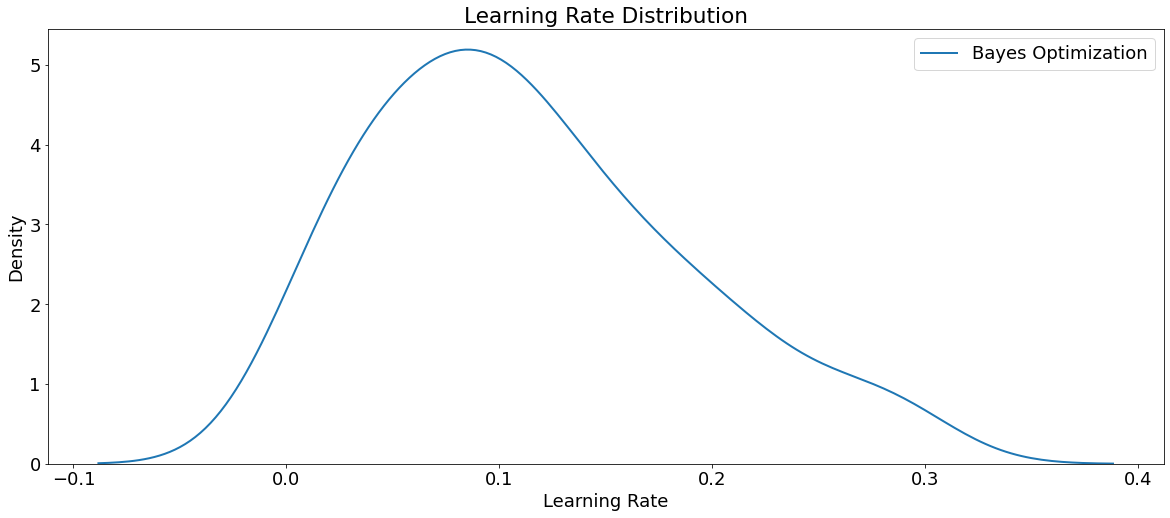

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

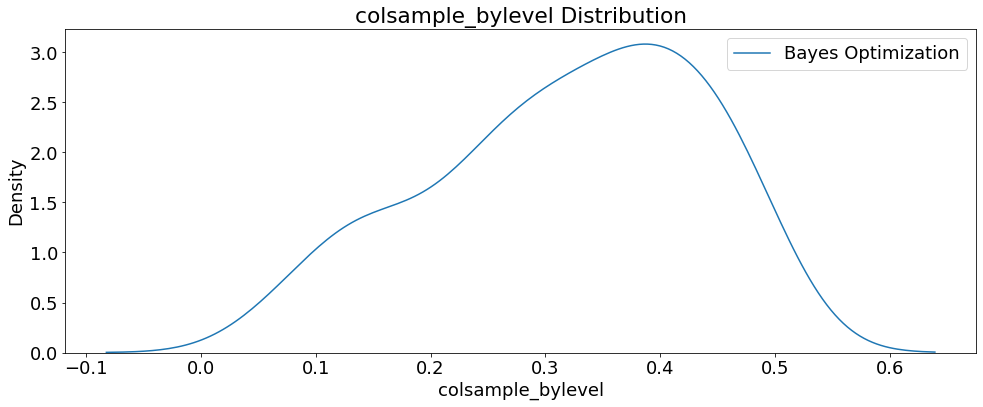

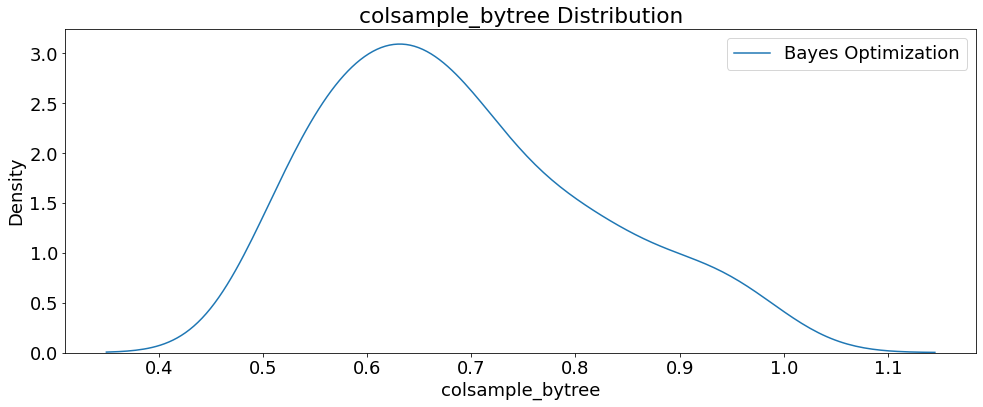

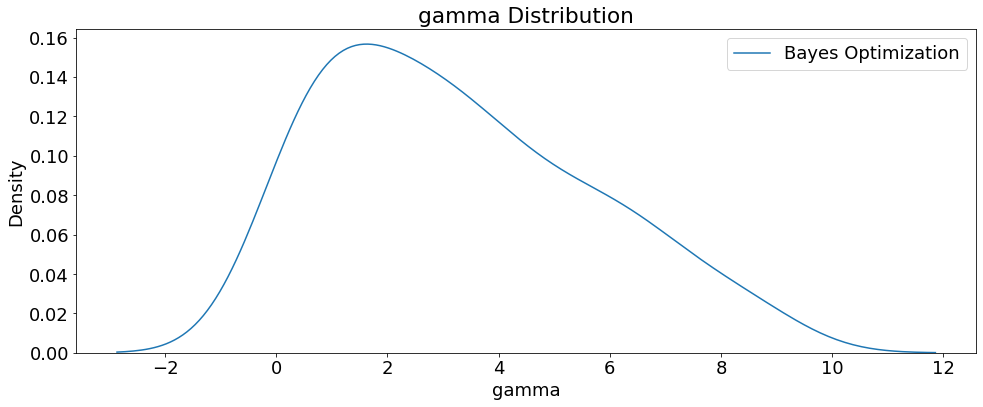

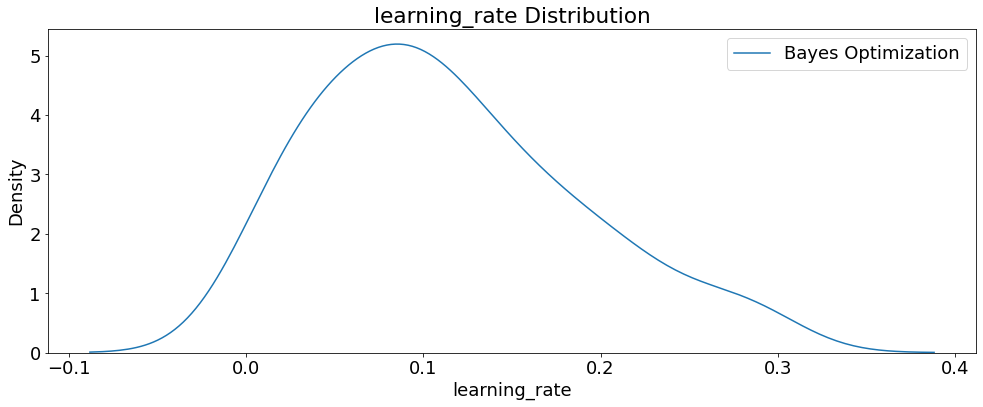

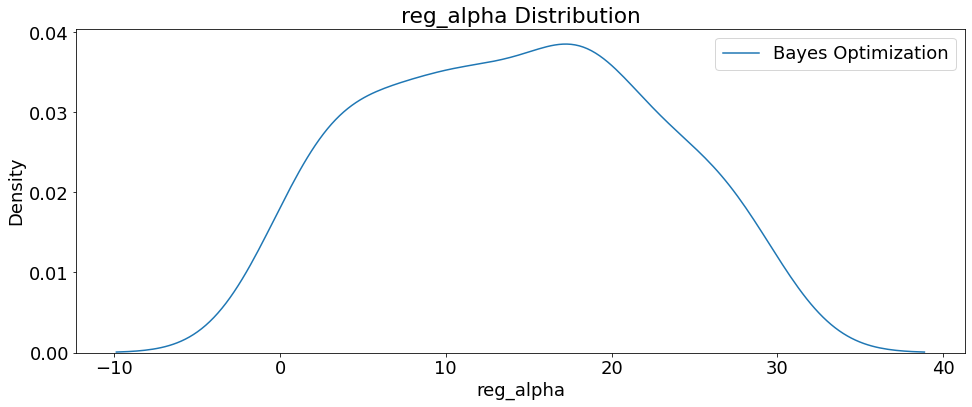

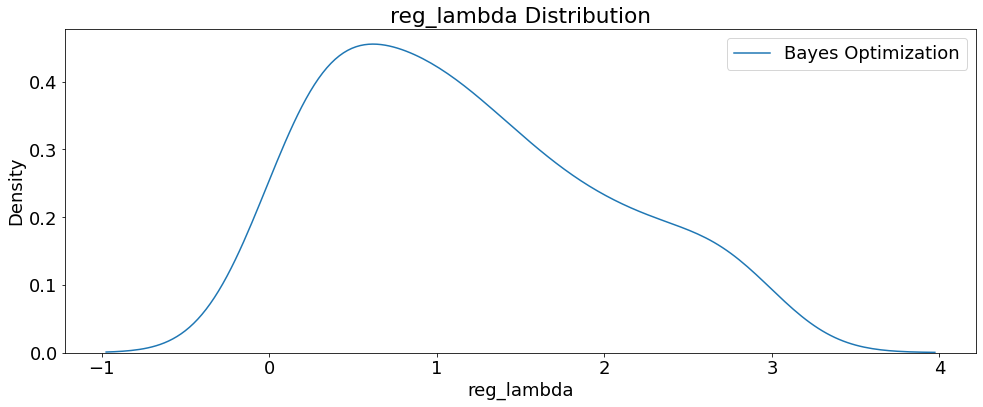

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

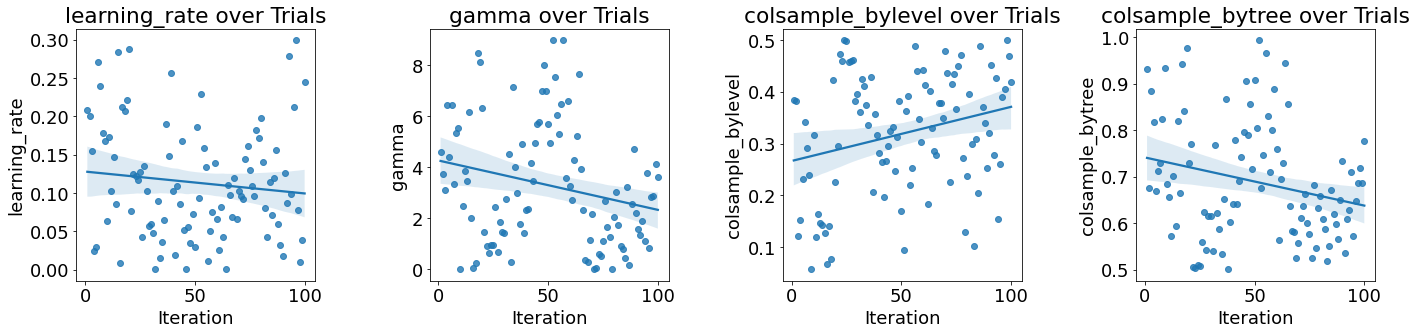

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

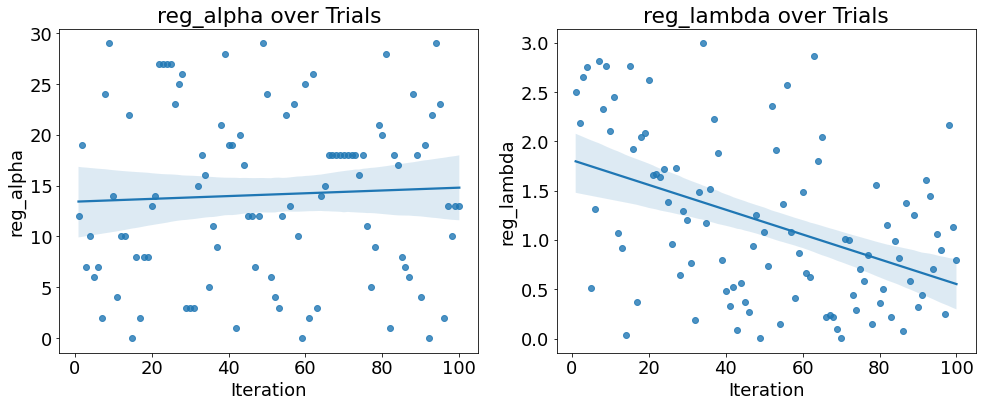

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']): 
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_Explanations


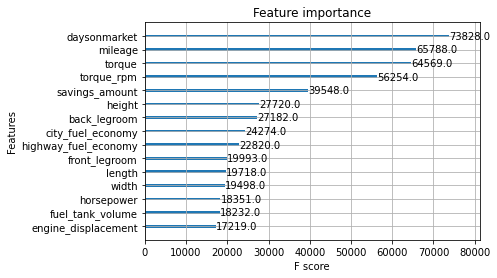

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features = 15)
plt.savefig('XGB_HPO_100_GPU_FeatureImportance_TimeCategories.png', 
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Training Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


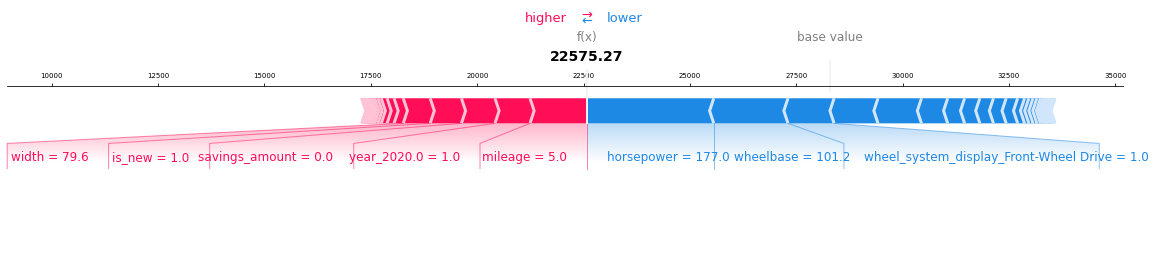

In [ ]:
# Visualize the first prediction's explanation
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], 
                show=False, matplotlib=True).savefig('XGB_HPO_100_GPU_ShapForcePlot_TrainSet_TimeCategories.png', 
                                                     dpi=my_dpi*10, 
                                                     bbox_inches='tight');

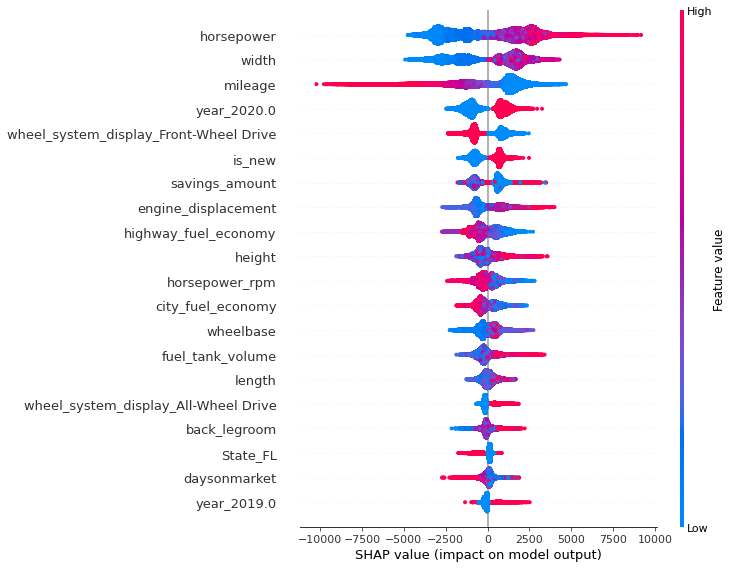

In [ ]:
# Training Set: Summarize the effects of all the features
shap.summary_plot(shap_values, X_train, show=False)
fig.savefig('XGB_HPO_100_GPU_ShapSummary_TrainSet_TimeCategories.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

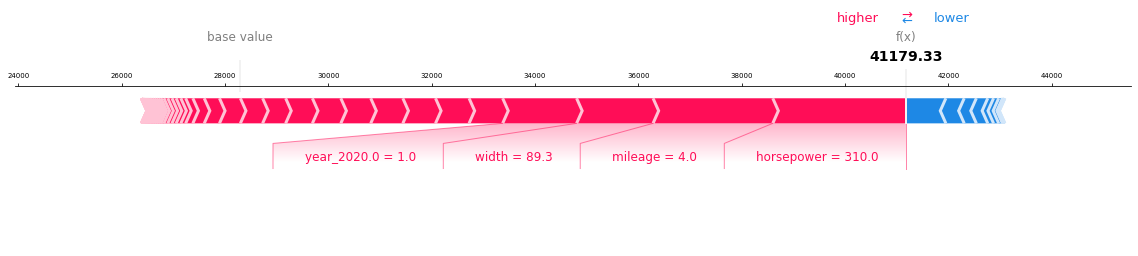

In [ ]:
# Visualize the first prediction's explanation
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], 
                show=False, matplotlib=True).savefig('XGB_HPO_100_GPU_ShapForcePlot_TestSet_TimeCategories.png', 
                                                     dpi=my_dpi*10, 
                                                     bbox_inches='tight');

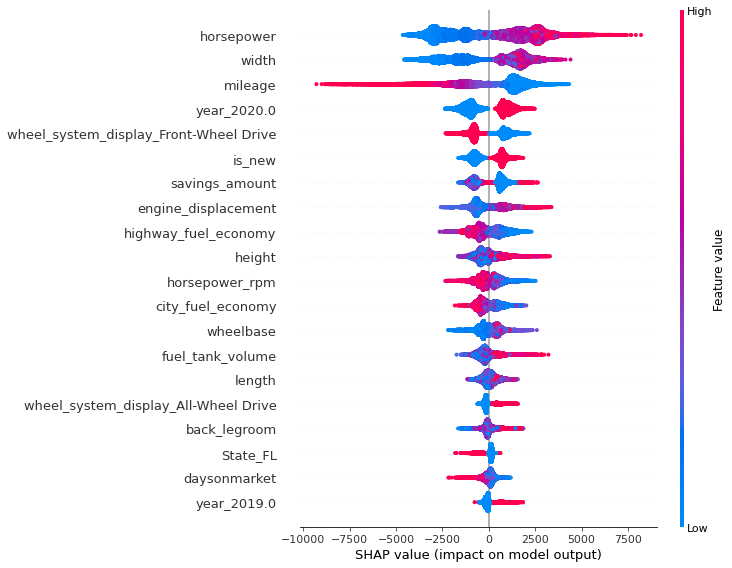

In [ ]:
# Test Set: Summarize the effects of all the features
shap.summary_plot(shap_values, X_test, show=False)
fig.savefig('XGB_HPO_100_GPU_ShapSummary_TestSet_TimeCategories.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

In [ ]:
# Get the weights
X_test1 = pd.DataFrame(X_test, columns=X_test.columns)                                                                    

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test1.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_100_GPU_TimeCategories_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_100_GPU_TimeCategories_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_100_GPU_TimeCategories_WeightsExplain.csv',
           index=False)

## Time Categories - 300 Trials 10-Fold Cross Validation 

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Define the number of trials
NUM_EVAL = 300

In [ ]:
# Define a function for optimization of hyperparameters
def xgb_hpo(config):
    """XGBoost HPO"""

    joblib.dump(bayesOpt_trials, 'xgb_Hyperopt_300_GPU_TimeCategories.pkl')

    # Keep track of evaluations
    global ITERATION
    
    ITERATION += 1  
    
    # Parameters that are integers to remain integers
    config['n_estimators'] = int(config['n_estimators'])   
    
    # Start hyperopt at 3 for max_depth   
    config['max_depth'] = int(config['max_depth']) + 3
    
    # Define model type
    xgb = XGBRegressor(
        objective='reg:squarederror',
        booster='gbtree', 
        tree_method='gpu_hist',    
        scale_pos_weight=1,
        use_label_encoder=False,
        early_stopping_rounds=10,
        random_state=seed_value,
        verbosity=0,
        **config)
    
    # Start timer for each trial
    start = timer()
    
    # Perform k_folds cross validation to find lower error
    scores = -cross_val_score(xgb, X_train, y_train,
                              scoring='neg_root_mean_squared_error',
                              cv=kfolds)
    run_time = timer() - start

    # Extract the best score
    rmse = np.mean(scores)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([rmse, config, ITERATION, run_time])
    
    return {'loss': rmse, 'params': config, 'iteration': ITERATION, 
            'train_time': run_time, 'status': STATUS_OK}    

In [ ]:
# File to save first results
out_file = '/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/trialOptions/XGB_300_GPU_TimeCategories.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global ITERATION
ITERATION = 0
bayesOpt_trials = Trials()

In [ ]:
# Run HPO
if os.path.isfile('xgb_Hyperopt_300_GPU_TimeCategories.pkl'): 
    bayesOpt_trials = joblib.load('xgb_Hyperopt_300_GPU_TimeCategories.pkl')
    best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest, 
                      max_evals=NUM_EVAL, trials=bayesOpt_trials,
                      rstate=np.random.RandomState(42))
else: 
    best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest, 
                      max_evals=NUM_EVAL, trials=bayesOpt_trials,
                      rstate=np.random.RandomState(42))

100%|██████████| 100/100 [13:19:15<00:00, 154.32s/it, best loss: 2368.5158474003733]


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/trialOptions/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/trialOptions


In [ ]:
# Access results
results = pd.read_csv('XGB_300_GPU_TimeCategories.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_model = XGBRegressor(objective='reg:squarederror', 
                                booster='gbtree',
                                tree_method='gpu_hist', 
                                scale_pos_weight=1,
                                use_label_encoder=False,                           
                                random_state=seed_value, 
                                verbosity=0, 
                                **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGB_HPO_trials300_GPU_TimeCategories.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGB_HPO_trials300_GPU_TimeCategories.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for XGBoost HPO 300 GPU trials Time Categories')
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))


Model Metrics for XGBoost HPO 300 GPU trials Time Categories
MAE train: 1204.859, test: 1721.774
MSE train: 2727363.124, test: 5560348.385
RMSE train: 1651.473, test: 2358.039
R^2 train: 0.970, test: 0.939


In [ ]:
# Evaluate on the testing data 
print('The best model from Bayes optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test, 
                                                                                                            y_test_pred)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 5560348.38503 MSE on the test set.
This was achieved after 224 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/bayesParams/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_XGB_HPO_300_GPU_TimeCategories.csv', 
                    index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

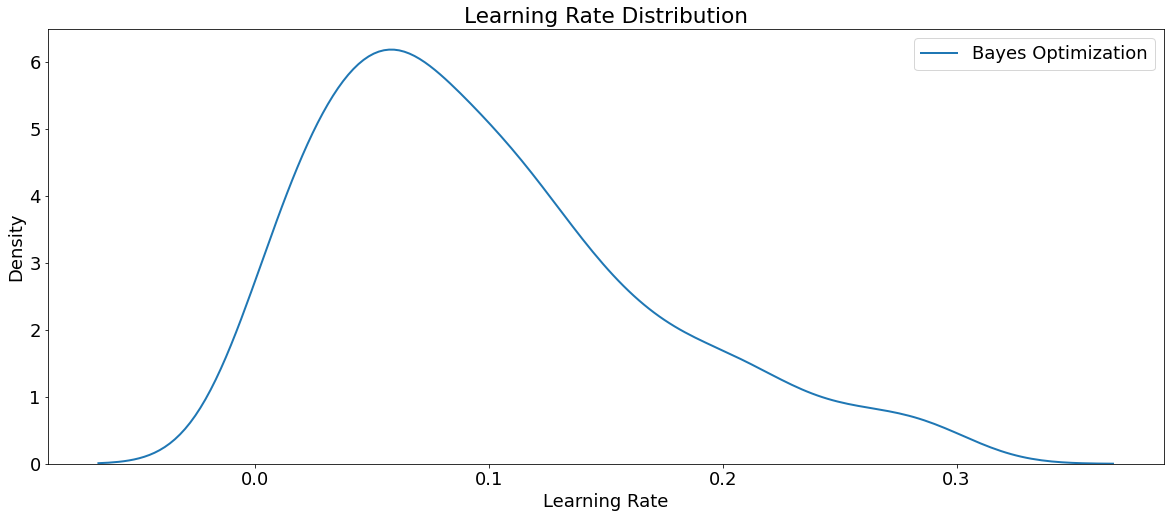

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

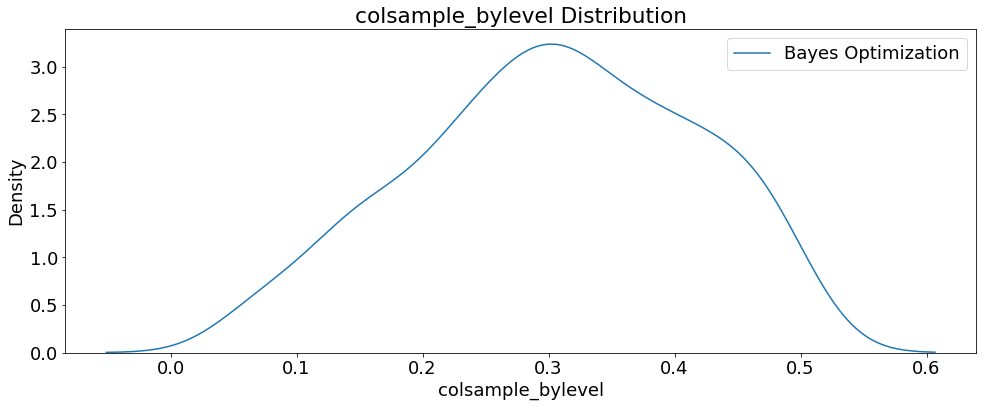

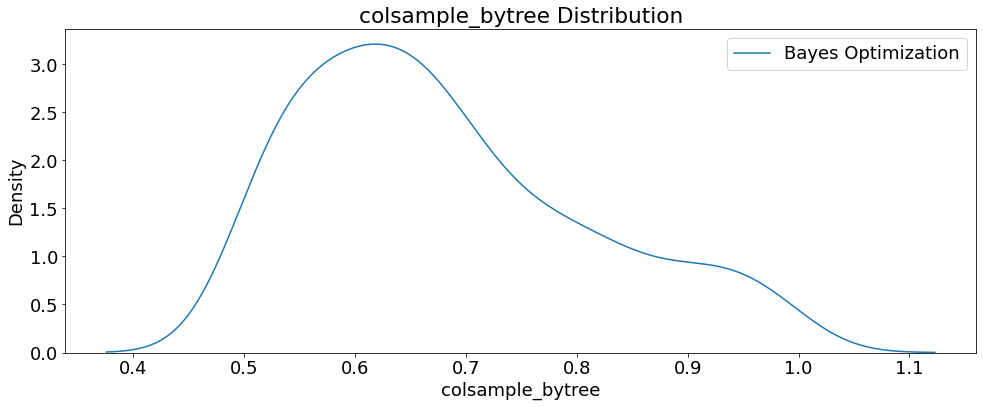

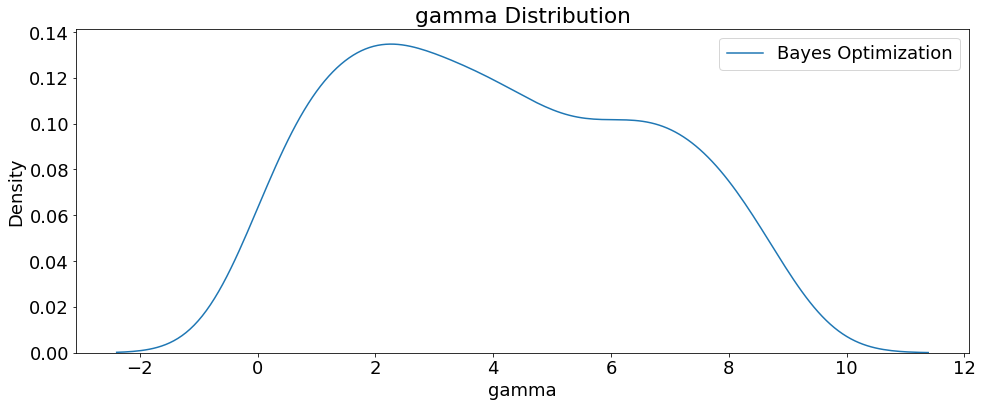

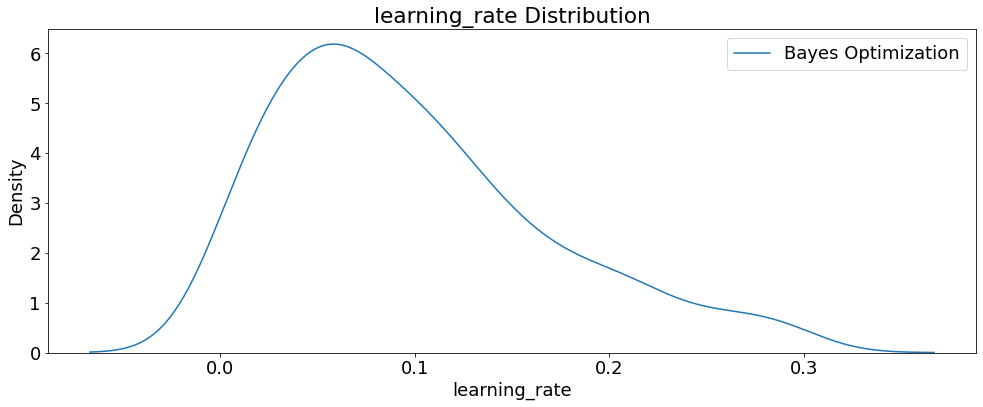

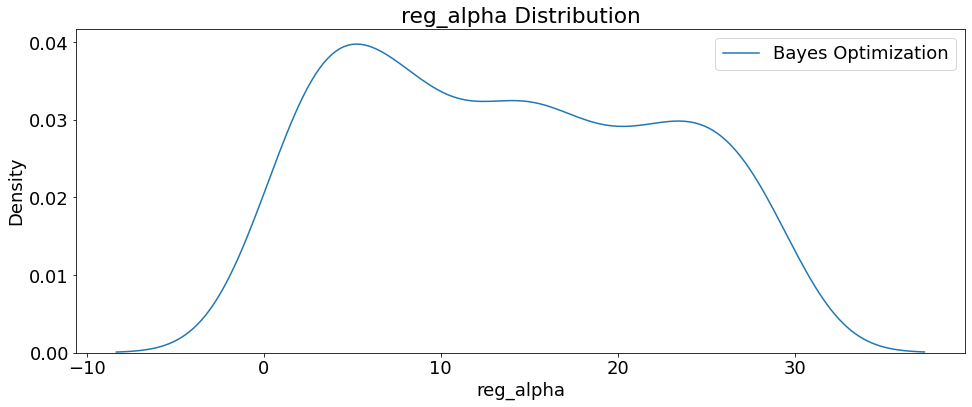

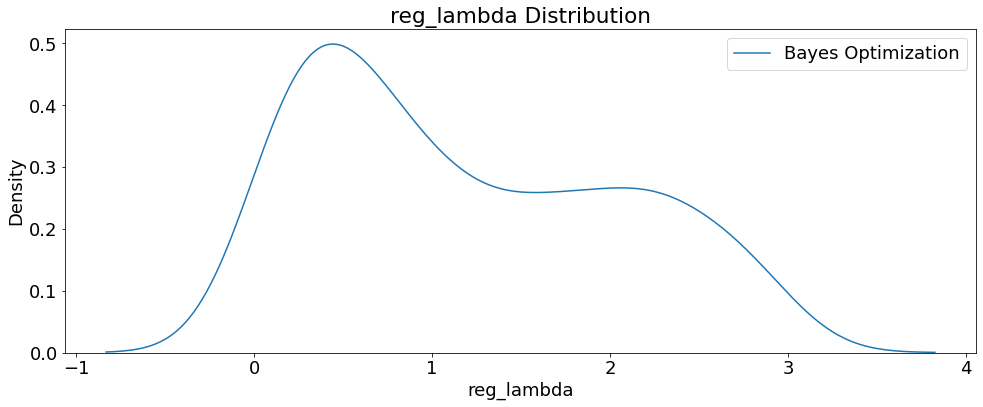

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

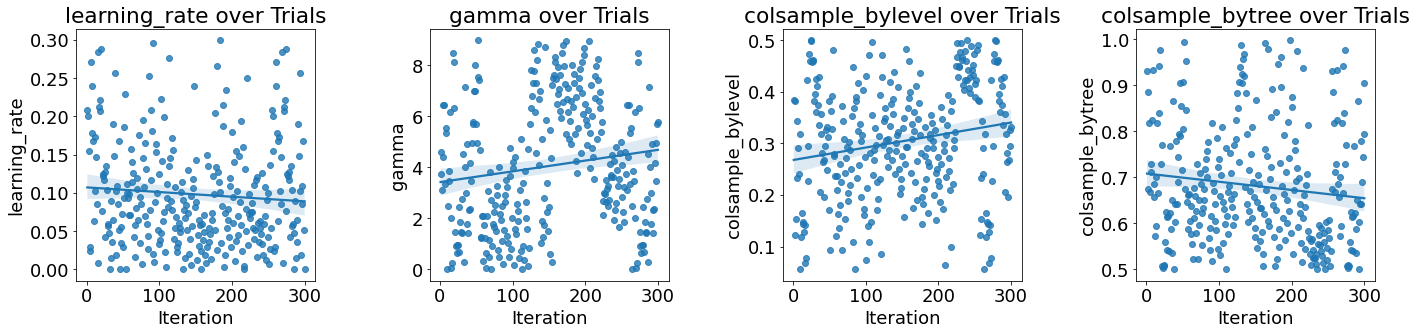

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

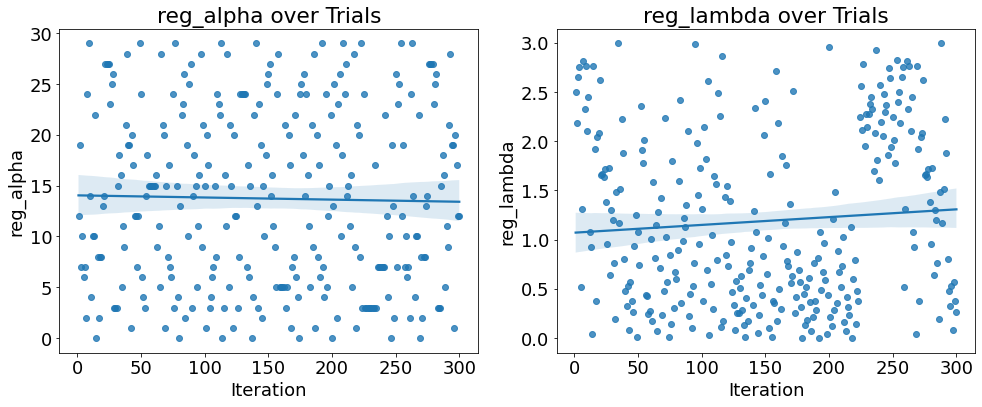

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']): 
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_Explanations


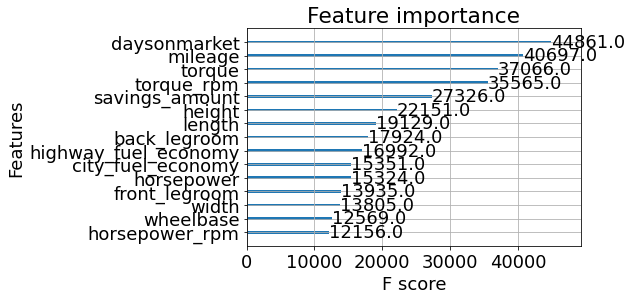

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGB_HPO_300_GPU_FeatureImportance_TimeCategories.png', 
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Training Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_train)

<Figure size 432x288 with 0 Axes>

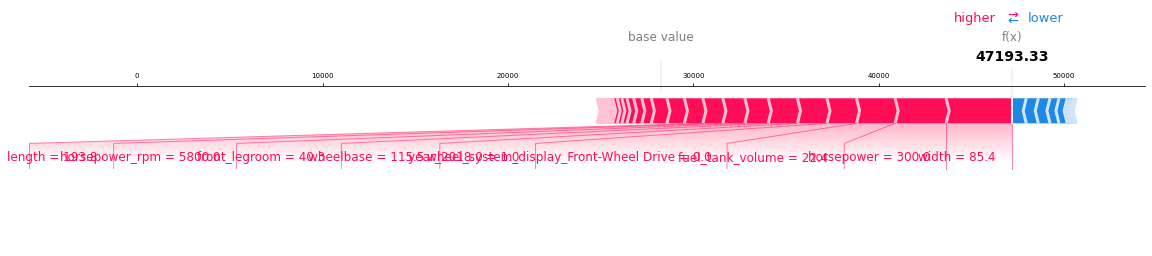

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], 
                show=False, matplotlib=True).savefig('XGB_HPO_300_GPU_ShapForcePlot_TrainSet_TimeCategories.png', 
                                                     dpi=my_dpi*10, 
                                                     bbox_inches='tight');

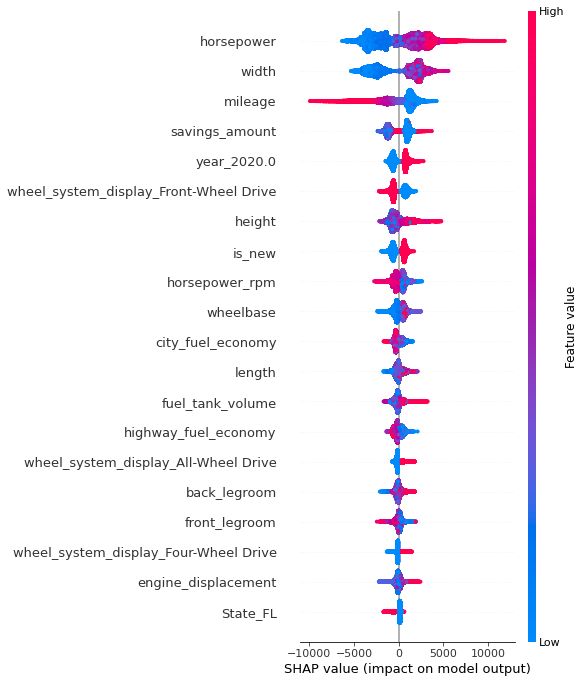

In [ ]:
# Training Set: Summarize the effects of all the features
shap.summary_plot(shap_values, X_train, show=False)
fig.savefig('XGB_HPO_300_GPU_ShapSummary_TrainSet_TimeCategories.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
shap_values = explainer.shap_values(X_test)

<Figure size 432x288 with 0 Axes>

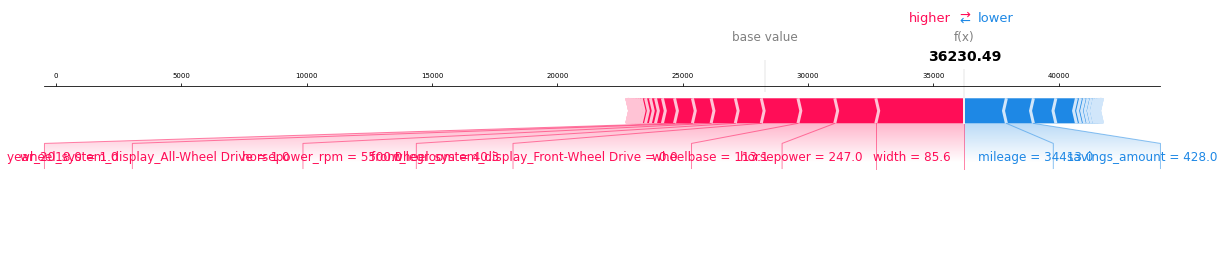

In [ ]:
# Visualize the first prediction's explanation
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], 
                show=False, matplotlib=True).savefig('XGB_HPO_300_GPU_ShapForcePlot_TestSet_TimeCategories.png', 
                                                     dpi=my_dpi*10, 
                                                     bbox_inches='tight');

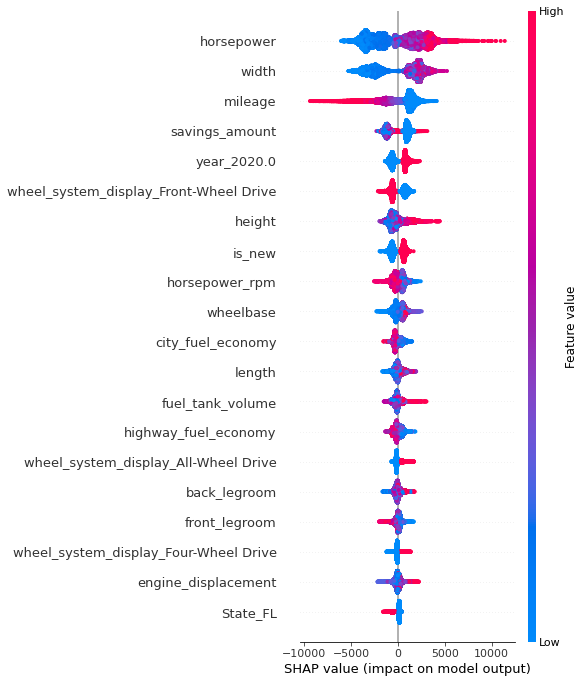

In [ ]:
# Test Set: Summarize the effects of all the features
shap.summary_plot(shap_values, X_test, show=False)
fig.savefig('XGB_HPO_300_GPU_ShapSummary_TestSet_TimeCategories.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

In [ ]:
# Get the weights
X_test1 = pd.DataFrame(X_test, columns=X_test.columns)                                                                    

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test1.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_300_GPU_TimeCategories_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_300_GPU_TimeCategories_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_300_GPU_TimeCategories_WeightsExplain.csv',
           index=False)
exp

feature    weight       std
0                               horsepower  0.254729  0.001539
1                                    width  0.122044  0.001048
2                                  mileage  0.087646  0.000694
3                                   height  0.052843  0.000256
4                              year_2020.0  0.029389  0.000311
5                                wheelbase  0.027210  0.000110
6                           savings_amount  0.025634  0.000177
7                          maximum_seating  0.023833  0.000099
8                                   is_new  0.020402  0.000132
9   wheel_system_display_Front-Wheel Drive  0.020195  0.000297
10                                  length  0.019826  0.000088
11                        fuel_tank_volume  0.017241  0.000190
12                          horsepower_rpm  0.017235  0.000164
13                       city_fuel_economy  0.015006  0.000120
14                           front_legroom  0.014976  0.000080
15                            back_legroom  0.014620  0.000052
16                    highway_fuel_economy  0.013915  0.000119
17                     engine_displacement  0.012535  0.000152
18   wheel_system_display_Four-Wheel Drive  0.008660  0.000061
19    wheel_system_display_All-Wheel Drive  0.006900  0.000227